# Deep Learning for Computer Vision

---

**Goethe University Frankfurt am Main**

Winter Semester 2022/23

<br>

## *Assignment 7 (Recurrent Neural Networks)*

---

**Points:** 110<br>
**Due:** 11.01.2023, 10 am<br>
**Contact:** Matthias Fulde ([fulde@cs.uni-frankfurt.de](mailto:fulde@cs.uni-frankfurt.de))<br>

---

**Your Name:** Tilo-Lars Flasche

<br>

<br>

## Table of Contents

---

- [1 Recurrent Neural Network](#1-Recurrent-Neural-Network-(20-Points))
  - [1.1 RNN Cell](#1.1-RNN-Cell-(10-Points))
  - [1.2 RNN Implementation](#1.2-RNN-Implementation-(10-Points))
- [2 Long Short-Term Memory Network](#2-Long-Short-Term-Memory-Network-(40-Points))
  - [2.1 LSTM Cell](#2.1-LSTM-Cell-(25-Points))
  - [2.2 LSTM Implementation](#2.2-LSTM-Implementation-(15-Points))
- [3 Gated Recurrent Unit Network](#3-Gated-Recurrent-Unit-Network-(30-Points))
  - [3.1 GRU Cell](#3.1-GRU-Cell-(20-Points))
  - [3.2 GRU Implementation](#3.2-GRU-Implementation-(10-Points))
- [4 Vanishing Gradients](#4-Vanishing-Gradients-(20-Points))


<br>

## Setup

---

In this problem set we work with PyTorch, NumPy and Matplotlib. [This page](https://pytorch.org/get-started/locally/) provides some information on how to install PyTorch on your system.

We set the Matplotlib backend to inline in order to display images directly in the notebook. In addition, we enable autoreloading so that saved changes in imported modules are applied without the need to manually reaload the modules every time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Display images in the notebook.
%matplotlib inline

# Enable autoreloading of imported modules.
%load_ext autoreload
%autoreload 2

We load the PyTorch library that allows us to perform the computations on the graphics card. You can check the GPU support of your environment with the statements below. However, in this problem set we can safely use the CPU, since we're not going to do a lot of training.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# Check GPU support on your machine.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


C:\Users\tilof\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Finally we load some utility functions to show samples from the dataset, train a model and check its accuracy.

In [3]:
from utils import show_images, check_accuracy, train

<br>

## Dataset

---

In this problem set we're working with the MNIST dataset of handwritten digits. The dataset consists of 60000 grayscale images for training and 10000 images for testing. We're loading the dataset from the PyTorch repository and split off a dataset for validation.

In [4]:
# Set number of samples per batch.
batch_size = 64

# Convert input images to tensors.
transform = T.ToTensor()

# Load and transform training set.
data_train = torchvision.datasets.MNIST(
    root='./datasets',
    train=True,
    download=True,
    transform=transform
)

# Load and transform test set.
data_test = torchvision.datasets.MNIST(
    root='./datasets',
    train=False,
    download=True,
    transform=transform
)

# Split training set into sets for training and validation.
data_train, data_val = torch.utils.data.random_split(data_train, [50000, 10000])

# Create dataloader for training set.
loader_train = torch.utils.data.DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# Create dataloader for validation set.
loader_val = torch.utils.data.DataLoader(
    data_val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# Create dataloader for test set.
loader_test = torch.utils.data.DataLoader(
    data_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    drop_last=True
)

Let's have a look at how the images in the dataset look like.

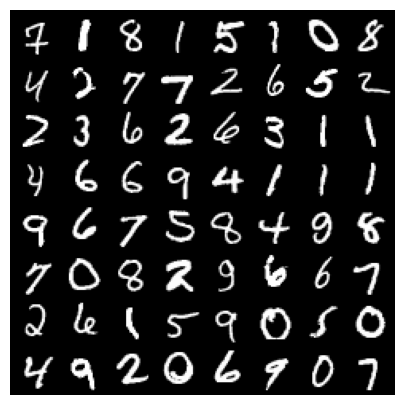

In [5]:
show_images(loader_train)

<br>

## Exercises

---

In this problem set, we're creating three recurrent neural networks that we train on an image classification task. In particular, we create a vanilla RNN, a LSTM network, and a GRU network and augment the models to classify digits from the MNIST dataset.

In order to accomplish this, we transform each image from the dataset into a sequence whose elements are fed into the networks one at a time. More precisely, we decompose each grayscale image into its rows, so that in each time step, the networks will get one row vector of an image as input.

Since the images in the MNIST dataset consist of $28\times28$ pixels, the sequence has 28 elements.

<br>

### 1 Recurrent Neural Network (20 Points)

---

We're going to start with the implementation of an image RNN based on the vanilla RNN architecture known from the lecture. That is, for time step $t$, the hidden state of a RNN cell is computed by

$$
    \mathbf{H}^{(t)} = \tanh(\mathbf{H}^{(t-1)}W_{hh} + \mathbf{X}^{(t)}W_{xh} + \mathbf{b}),
$$

<br>

where $\mathbf{H}^{(t-1)}$ is the previous hidden state, $\mathbf{X}^{(t)}$ is the current input, $W_{hh}$ and $W_{xh}$ are the weights and $b$ is the bias. As for the image classification task, we take the state vector of the last layer after the last time step and feed it into a linear layer to obtain the predictions.

<br>

### 1.1 RNN Cell (10 Points)

---

In this exercise we want to implement a simple RNN cell that takes an input and the previous hidden state and computes a new state.

<br>

#### 1.1.1 Task

Complete the definition of the `forward` method in the definition of the `RNNCell` class below.

<br>

#### 1.1.2 Solution

Write your solution in the delimited area.

In [6]:
class RNNCell(nn.Module):

    def __init__(self, input_dim, hidden_dim):
        """
        Implementation of a simple RNN cell.

        Parameters:
            - input_dim (int): Size of input vector.
            - hidden_dim (int): Size of hidden state vector.

        """
        super().__init__()

        # Create and initialize weight matrices.
        self.weights_xh = nn.init.xavier_uniform_(torch.empty(input_dim, hidden_dim))
        self.weights_hh = nn.init.xavier_uniform_(torch.empty(hidden_dim, hidden_dim))

        # Create and initialize bias.
        self.bias = torch.zeros(1, hidden_dim)


    def forward(self, x, h_prev):
        """
        Compute the forward pass through the cell.

        Parameters:
            - x (torch.tensor): Current input.
            - h_prev (torch.tensor): Previous hidden state.

        Returns:
            - h (torch.tensor): Current hidden state.

        """
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        # Compute the new hidden state vector
        h = F.tanh(h_prev @ self.weights_hh + x @ self.weights_xh + self.bias)

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return h

<br>

### 1.2 RNN Implementation (10 Points)

---

Now we want to implement a basic recurrent neural network using the RNN cell that we implemented above.

<br>

####  1.2.1 Task

Complete the `forward` method in the definition of the `RNN` class below. The method takes a sequence of inputs and optionally a state vector for initialization. It returns the outputs for each time step and the final output of the last RNN cell.

<br>

#### 1.2.2 Solution

Write your solution in the delimited area.

In [7]:
class RNN(nn.Module):

    def __init__(self, batch_size, num_layers, input_dim, hidden_dim, time_steps):
        """
        Implementation of a basic RNN model.
        
        Parameters:
            - batch_size (int): Number of samples.
            - num_layers (int): Number of layers.
            - input_dim (int): Size of input vectors.
            - hidden_dim (int): Size of hidden state vectors.
            - time_steps (int): Sequence length.

        """
        super().__init__()

        # Save batch size and sequence length.
        self.batch_size = batch_size
        self.time_steps = time_steps

        # Save dimensions.
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Create network layers.
        self.layers = [
            RNNCell(input_dim if n == 0 else hidden_dim, hidden_dim)
            for n in range(num_layers)
        ]

        # Initialize hidden state.
        self.h_init = torch.zeros(num_layers, batch_size, hidden_dim)


    def forward(self, x, h_init=None):
        """
        Compute forward pass through the network.

        Parameters:
            - x: Sequence of inputs.
            - h_init (torch.tensor): Initial hidden states.

        Returns:
            - y (torch.tensor): List of outputs for each time step.
            - h (torch.tensor): Output layer state after last time step.

        """
        # Create array for outputs.
        y = torch.empty(self.time_steps, self.batch_size, self.hidden_dim)

        # Initialize hidden states.
        h_init = self.h_init if h_init is None else h_init

        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        # For the first item of the sequence there is no previous hidden state,
        # so we initialize the previous hidden state as a tensor of zeros
        h_prev = h_init
        
        # The current hidden state is also set to zero, because before we pass the
        # first item through the RNN there is no information encoded in the hiden state
        h = torch.empty(h_init.shape)
                
        # Iterate over sequence
        for t in range(x.size(0)):
            # Iterate over hidden layers
            for n in range(len(self.layers)):
                if n == 0:
                    # The first hidden layer consumes the t-th item rom the input seqeuence
                    # and the last hidden state of layer 0
                    h[n:n+1] = self.layers[n](x[t], h_prev[n])
                else:
                    # All the other hidden layers consume the hidden state from layer n-1 as input
                    # and the last hidden state from layer n-1
                    h[n:n+1] = self.layers[n](h[n-1], h_prev[n])
        
            # The current hidden state becomes the new previous hidden state in the next iteration
            h_prev = h
            
        y = h[len(self.layers) - 1]
        h = h[len(self.layers) - 1]
                    
        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################

        return y, h

Now that we have a recurrent neural network, we can test our implementation on the loaded dataset with the following extension of our model. If you want to compare your implementation with the library version of PyTorch, you can replace the call to our own class with a call to [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) in the constructor, providing the input size, hidden size, and number of layers.

In [8]:
class ImageRNN(nn.Module):

    def __init__(self, batch_size, num_layers, input_dim, hidden_dim, output_dim, time_steps):
        """
        Creates a RNN for image classification.

        Parameters:
            - batch_size (int): Number of samples.
            - num_layers (int): Number of layers.
            - input_dim (int): Size of input vectors.
            - hidden_dim (int): Size of hidden state vectors.
            - output_dim (int): Size of output vector.
            - time_steps (int): Number of steps.

        """
        super().__init__()

        # Store number of layers, samples and time steps.
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.time_steps = time_steps

        # Store dimensions.
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Create basic recurrent neural network.
        self.rnn = RNN(batch_size, num_layers, input_dim, hidden_dim, time_steps)

        # Create final fully connected layer.
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        """
        Compute the forward pass through the network.

        Parameters:
            - x (torch.tensor): Image interpreted as sequence of inputs.

        Returns:
            - y (torch.tensor): Predictions.

        """

        # Transform input to sequence: time_steps X batch_size X input_dim.
        x = x.permute(1, 0, 2) 

        # Update batch size.
        self.batch_size = x.size(1)

        # Initialize hidden states.
        h_init = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)

        # Compute forward pass through recurrent neural network.
        _, h = self.rnn(x, h_init)

        # Compute forward pass through fully connected network.
        y = self.fc(h)

        # Reshape output.
        y = y.view(-1, self.output_dim)

        return y

Let's train the model for some epochs! If your implementation is correct, you should see more than $70 \%$ accuracy on the test set.

In [50]:
# Create the model.
model = ImageRNN(batch_size, num_layers=4, input_dim=28, hidden_dim=128, output_dim=10, time_steps=28)

# Create the loss function and optimizer.
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model for some epochs.
history = train(model, loss, optimizer, loader_train, loader_val, num_epochs=5)

# Check test accuracy.
print(f'\nTest accuracy: {check_accuracy(model, loader_test):.2f} %')

Epoch:   1/5  Loss: 1.19726  Train accuracy: 66.09 %  Val accuracy: 66.82 %
Epoch:   2/5  Loss: 1.11511  Train accuracy: 69.42 %  Val accuracy: 70.07 %
Epoch:   3/5  Loss: 0.68851  Train accuracy: 70.87 %  Val accuracy: 71.54 %
Epoch:   4/5  Loss: 0.84125  Train accuracy: 71.88 %  Val accuracy: 72.54 %
Epoch:   5/5  Loss: 0.89869  Train accuracy: 72.72 %  Val accuracy: 73.22 %

Test accuracy: 72.67 %


<br>

### 2 Long Short-Term Memory Network (40 Points)

---

Now let's follow the same path as in the previous exercise to obtain an image LSTM to do classification on the MNIST dataset. We're going to implement a plain LSTM and augment the network to classify the images.

<br>

### 2.1 LSTM Cell (25 Points)

---

In this exercise we want to implement a LSTM cell that takes an input, the previous hidden state and cell memory state and computes the next hidden state and cell memory state.

<br>

#### 2.1.1 Task

Complete the definition of the `forward` method in the definition of the `LSTMCell` class below.

<br>

#### 2.1.2 Solution

Write your solution in the delimited area.

In [31]:
class LSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim):
        """
        Implementation of a LSTM cell.

        Parameters:
            - input_dim (int): Size of input vector.
            - hidden_dim (int): Size of hidden state vector.

        """
        super().__init__()

        # Create input gate weights.
        self.weights_input_x = nn.init.xavier_uniform_(torch.randn(input_dim, hidden_dim))
        self.weights_input_h = nn.init.xavier_uniform_(torch.randn(hidden_dim, hidden_dim))

        # Create input gate bias.
        self.bias_input = torch.zeros(1, hidden_dim)
        
        # Create forget gate weights. 
        self.weights_forget_x = nn.init.xavier_uniform_(torch.randn(input_dim, hidden_dim))
        self.weights_forget_h = nn.init.xavier_uniform_(torch.randn(hidden_dim, hidden_dim))

        # Create forget gate bias.
        self.bias_forget = torch.zeros(1, hidden_dim)

        # Create cell memory weights.
        self.weights_cell_x = nn.init.xavier_uniform_(torch.randn(input_dim, hidden_dim))
        self.weights_cell_h = nn.init.xavier_uniform_(torch.randn(hidden_dim, hidden_dim))

        # Create cell memory bias.
        self.bias_cell = torch.zeros(1, hidden_dim)

        # Create output gate weights.
        self.weights_output_x = nn.init.xavier_uniform_(torch.randn(input_dim, hidden_dim))
        self.weights_output_h = nn.init.xavier_uniform_(torch.randn(hidden_dim, hidden_dim))

        # Create output gate bias.
        self.bias_output = torch.zeros(1, hidden_dim)    


    def forward(self, x, h_prev, c_prev):
        """
        Compute the forward pass through the cell.

        Parameters:
            - x (torch.tensor): Current input.
            - h_prev (torch.tensor): Previous hidden state.
            - c_prev (torch.tensor): Previous cell state.

        Returns:
            - h (torch.tensor): Current hidden state.
            - c (torch.tensor): Current cell state.

        """
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        # Input gate
        i = F.sigmoid(x @ self.weights_input_x + h_prev @ self.weights_input_h + self.bias_input)
        
        # Forget gate
        f = F.sigmoid(x @ self.weights_forget_x + h_prev @ self.weights_forget_h + self.bias_forget)
        
        # Output gate
        o = F.sigmoid(x @ self.weights_output_x + h_prev @ self.weights_output_h + self.bias_output)
        
        # Candidate values
        c_tilde = F.tanh(x @ self.weights_cell_x + h_prev @ self.weights_cell_h + self.bias_cell)
        
        # New cell state
        c = f * c_prev + i * c_tilde
                   
        # New hidden state
        h = o * F.tanh(c)

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return h, c

<br>

### 2.2 LSTM Implementation (15 Points)

---

Now we want to implement a basic LSTM network using the LSTM cell that we implemented above.

<br>

#### 2.2.1 Task

Complete the `forward` method in the definition of the `LSTM` class below. The method takes a sequence of inputs an optionally hidden state and cell state vectors for initialization. It returns the outputs for each time step and the final hidden state of the last LSTM cell.

<br>

#### 2.2.2 Solution

Write your solution in the delimited area.

In [32]:
class LSTM(nn.Module):

    def __init__(self, batch_size, num_layers, input_dim, hidden_dim, time_steps):
        """
        Implementation of a basic LSTM model.

        Parameters:
            - batch_size (int): Number of samples.
            - num_layers (int): Number of layers.
            - input_dim (int): Size of input vectors.
            - hidden_dim (int): Size of hidden state vectors.
            - time_steps (int): Sequence length.

        """
        super().__init__()

        # Store number of layers, samples and time steps.
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.time_steps = time_steps

        # Store dimensions.
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Create network layers.
        self.layers = [
            LSTMCell(input_dim if n == 0 else hidden_dim, hidden_dim)
            for n in range(num_layers)
        ]

        # Initialize hidden state and cell state.
        self.h_init = torch.zeros(num_layers, batch_size, hidden_dim)
        self.c_init = torch.zeros(num_layers, batch_size, hidden_dim)


    def forward(self, x, h_init=None, c_init=None):
        """
        Compute forward pass through the network.

        Parameters:
            - x (torch.tensor): Sequence of inputs.
            - h_init (torch.tensor): Initial hidden state.
            - c_init (torch.tensor): Initial cell state.

        Returns:
            - y (torch.tensor): List of outputs for each time step.
            - h (torch.tensor): Hidden state of last layer after last time step.

        """
        # Create array for outputs.
        y = torch.empty(self.time_steps, self.batch_size, self.hidden_dim)

        # Initialize hidden state and cell states.
        h_init = self.h_init if h_init is None else h_init
        c_init = self.c_init if c_init is None else c_init

        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        # For the first item of the sequence there is no previous hidden state,
        # so we initialize the previous hidden state as a tensor of zeros
        h_prev = h_init
        c_prev = c_init
        
        # The current hidden state is also set to zero, because before we pass the
        # first item through the RNN there is no information encoded in the hiden state
        h = torch.empty(h_init.shape)
        c = torch.empty(c_init.shape)
                
        # Iterate over sequence
        for t in range(x.size(0)):
            # Iterate over hidden layers
            for n in range(len(self.layers)):
                if n == 0:
                    # The first hidden layer consumes the t-th item rom the input seqeuence
                    # and the last hidden state of layer 0
                    h[n:n+1], c[n:n+1] = self.layers[n](x[t], h_prev[n], c_prev[n])
                else:
                    # All the other hidden layers consume the hidden state from layer n-1 as input
                    # and the last hidden state from layer n-1
                    h[n:n+1], c[n:n+1] = self.layers[n](h[n-1], h_prev[n], c_prev[n])
        
            # The current hidden state becomes the new previous hidden state in the next iteration
            h_prev = h
            c_prev = c
            
        y = h[len(self.layers) - 1]
        h = h[len(self.layers) - 1]
        
        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return y, h

Now that we have a recurrent neural network, we can test our implementation on the loaded dataset with the following extension of our model. If you want to compare your implementation with the library version of PyTorch, you can replace the call to our own class with a call to [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) in the constructor, providing the number of layers, the input size and hidden size.

In [33]:
class ImageLSTM(nn.Module):

    def __init__(self, batch_size, num_layers, input_dim, hidden_dim, output_dim, time_steps):
        """
        Creates a LSTM for image classification.

        Parameters:
            - batch_size (int): Number of samples.
            - num_layers (int): Number of layers.
            - input_dim (int): Size of input vectors.
            - hidden_dim (int): Size of hidden state vectors.
            - output_dim (int): Size of output vector.
            - time_steps (int): Number of steps.

        """
        super().__init__()

        # Store number of layers, samples and steps.
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.time_steps = time_steps

        # Store dimensions.
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Create basic LSTM network.
        self.lstm = LSTM(batch_size, num_layers, input_dim, hidden_dim, time_steps) 

        # Create fully connected network.
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        """
        Compute the forward pass through the network.

        Parameters:
            - x (torch.tensor): Image interpreted as sequence of inputs.

        Returns:
            - y (torch.tensor): Predictions.

        """

        # Transform input to sequence: time_steps X batch_size X input_dim.
        x = x.permute(1, 0, 2)

        # Update batch size.
        self.batch_size = x.size(1)

        # Initialize hidden and cell state.
        h_init = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)
        c_init = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)

        # Compute forward pass through LSTM network.
        _, h = self.lstm(x, h_init, c_init)

        # Compute forward pass through FC network.
        y = self.fc(h)

        # Reshape output.
        y = y.view(-1, self.output_dim)

        return y

Let's train the model for some epochs! If your implementation is correct, you should see more than $60 \%$ accuracy on the test set.

In [34]:
# Create the model.
model = ImageLSTM(batch_size, num_layers=2, input_dim=28, hidden_dim=128, output_dim=10, time_steps=28)

# Create the loss function and optimizer.
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model for some epochs.
history = train(model, loss, optimizer, loader_train, loader_val, num_epochs=5)

# Check test accuracy.
print(f'\nTest accuracy: {check_accuracy(model, loader_test):.2f} %')

Epoch:   1/5  Loss: 1.32313  Train accuracy: 57.26 %  Val accuracy: 56.68 %
Epoch:   2/5  Loss: 1.34146  Train accuracy: 62.23 %  Val accuracy: 62.10 %
Epoch:   3/5  Loss: 1.13398  Train accuracy: 63.81 %  Val accuracy: 63.75 %
Epoch:   4/5  Loss: 1.05726  Train accuracy: 65.62 %  Val accuracy: 65.52 %
Epoch:   5/5  Loss: 0.85640  Train accuracy: 67.09 %  Val accuracy: 66.87 %

Test accuracy: 67.53 %


<br>

### 3 Gated Recurrent Unit Network (30 Points)

---

Lastly we use the same framework to obtain an image GRU to do classification on the MNIST dataset. We're going to implement a GRU network and augment the network to classify the images.

<br>

### 3.1 GRU Cell (20 Points)

---

In this exercise we want to implement a GRU cell that takes an input, the previous hidden state and computes the next hidden state.

<br>

#### 3.1.1 Task

Complete the definition of the `forward` method in the definition of the `GRUCell` class below.

<br>

#### 3.1.2 Solution

Write your solution in the delimited area.

In [27]:
class GRUCell(nn.Module):

    def __init__(self, input_dim, hidden_dim):
        """
        Implementation of a GRU cell.

        Parameters:
            - input_dim (int): Size of input vector.
            - hidden_dim (int): Size of hidden state vector.

        """
        super().__init__()

        # Create reset gate weights.
        self.weights_reset_x = nn.init.xavier_uniform_(torch.randn(input_dim, hidden_dim))
        self.weights_reset_h = nn.init.xavier_uniform_(torch.randn(hidden_dim, hidden_dim))

        # Create reset gate bias.
        self.bias_reset = torch.zeros(1, hidden_dim)

        # Create update gate weights. 
        self.weights_update_x = nn.init.xavier_uniform_(torch.randn(input_dim, hidden_dim))
        self.weights_update_h = nn.init.xavier_uniform_(torch.randn(hidden_dim, hidden_dim))

        # Create update gate bias.
        self.bias_update = torch.zeros(1, hidden_dim)

        # Create candidate hidden state weights.
        self.weights_hidden_x = nn.init.xavier_uniform_(torch.randn(input_dim, hidden_dim))
        self.weights_hidden_h = nn.init.xavier_uniform_(torch.randn(hidden_dim, hidden_dim))

        # Create candidate hidden state bias.
        self.bias_hidden = torch.zeros(1, hidden_dim)


    def forward(self, x, h_prev):
        """
        Compute the forward pass through the cell.

        Parameters:
            - x (torch.tensor): Current input.
            - h_prev (torch.tensor): Previous hidden state.

        Returns:
            - h (torch.tensor): Current hidden state.

        """
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################
        
        # Compute Reset gate output
        r = F.sigmoid(x @ self.weights_reset_x + h_prev @ self.weights_reset_h + self.bias_reset)
        
        # Compute Update Gate output
        z = F.sigmoid(x @ self.weights_update_x + h_prev @ self.weights_update_h + self.bias_update)
        
        # Compute candidate hidden state
        h_tilde = F.tanh((r * h_prev) @ self.weights_hidden_h + x @ self.weights_hidden_x + self.bias_hidden)

        # Compute new hidden state
        h = z * h_prev + (1 - z) * h_tilde

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return h

<br>

### 3.2 GRU Implementation (10 Points)

---

Now we want to implement a GRU network using the GRU cell that we implemented above.

<br>

#### 3.2.1 Task

Complete the `forward` method in the definition of the `GRU` class below. The method takes a sequence of inputs an optionally a hidden state vector for initialization. It returns the outputs for each time step and the final hidden state of the last GRU cell.

<br>

#### 3.2.2 Solution

Write your solution in the delimited area.

In [28]:
class GRU(nn.Module):

    def __init__(self, batch_size, num_layers, input_dim, hidden_dim, time_steps):
        """
        Implementation of a basic GRU model.

        Parameters:
            - batch_size (int): Number of samples.
            - num_layers (int): Number of layers.
            - input_dim (int): Size of input vectors.
            - hidden_dim (int): Size of hidden state vectors.
            - time_steps (int): Sequence length.

        """
        super().__init__()

        # Store number of layers, samples and time steps.
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.time_steps = time_steps

        # Store dimensions.
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Create network layers.
        self.layers = [
            GRUCell(input_dim if n == 0 else hidden_dim, hidden_dim)
            for n in range(num_layers)
        ]

        # Initialize hidden state state.
        self.h_init = torch.zeros(num_layers, batch_size, hidden_dim)


    def forward(self, x, h_init=None):
        """
        Compute forward pass through the network.

        Parameters:
            - x (torch.tensor): Sequence of inputs.
            - h_init (torch.tensor): Initial hidden state.

        Returns:
            - y (torch.tensor): List of outputs for each time step.
            - h (torch.tensor): Hidden state of last layer after last time step.

        """
        # Create array for outputs.
        y = torch.empty(self.time_steps, self.batch_size, self.hidden_dim)

        # Initialize hidden state and cell states.
        h_init = self.h_init if h_init is None else h_init

        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        # For the first item of the sequence there is no previous hidden state,
        # so we initialize the previous hidden state as a tensor of zeros
        h_prev = h_init
        
        # The current hidden state is also set to zero, because before we pass the
        # first item through the RNN there is no information encoded in the hiden state
        h = torch.empty(h_init.shape)
                
        # Iterate over sequence
        for t in range(x.size(0)):
            # Iterate over hidden layers
            for n in range(len(self.layers)):
                if n == 0:
                    # The first hidden layer consumes the t-th item rom the input seqeuence
                    # and the last hidden state of layer 0
                    h[n:n+1] = self.layers[n](x[t], h_prev[n])
                else:
                    # All the other hidden layers consume the hidden state from layer n-1 as input
                    # and the last hidden state from layer n-1
                    h[n:n+1] = self.layers[n](h[n-1], h_prev[n])
        
            # The current hidden state becomes the new previous hidden state in the next iteration
            h_prev = h
            
        y = h[len(self.layers) - 1]
        h = h[len(self.layers) - 1]

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return y, h

Now that we have a recurrent neural network, we can test our implementation on the loaded dataset with the following extension of our model. If you want to compare your implementation with the library version of PyTorch, you can replace the call to our own class with a call to [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU) in the constructor, providing the number of layers, the input size and hidden size.

In [29]:
class ImageGRU(nn.Module):

    def __init__(self, batch_size, num_layers, input_dim, hidden_dim, output_dim, time_steps):
        """
        Creates a GRU for image classification.

        Parameters:
            - batch_size (int): Number of samples.
            - num_layers (int): Number of layers.
            - input_dim (int): Size of input vectors.
            - hidden_dim (int): Size of hidden state vectors.
            - output_dim (int): Size of output vector.
            - time_steps (int): Number of steps.

        """
        super().__init__()

        # Store number of layers, samples and steps.
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.time_steps = time_steps

        # Store dimensions.
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Create basic LSTM network.
        self.gru = GRU(batch_size, num_layers, input_dim, hidden_dim, time_steps) 

        # Create fully connected network.
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        """
        Compute the forward pass through the network.

        Parameters:
            - x (torch.tensor): Image interpreted as sequence of inputs.

        Returns:
            - y (torch.tensor): Predictions.

        """

        # Transform input to sequence: time_steps X batch_size X input_dim.
        x = x.permute(1, 0, 2)

        # Update batch size.
        self.batch_size = x.size(1)

        # Initialize hidden state.
        h_init = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)

        # Compute forward pass through LSTM network.
        _, h = self.gru(x, h_init)

        # Compute forward pass through FC network.
        y = self.fc(h)

        # Reshape output.
        y = y.view(-1, self.output_dim)

        return y

Let's train the model for some epochs! If your implementation is correct, you should see more than $70 \%$ accuracy on the test set.

In [30]:
# Create the model.
model = ImageGRU(batch_size, num_layers=2, input_dim=28, hidden_dim=128, output_dim=10, time_steps=28)

# Create the loss function and optimizer.
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model for some epochs.
history = train(model, loss, optimizer, loader_train, loader_val, num_epochs=5)

# Check test accuracy.
print(f'\nTest accuracy: {check_accuracy(model, loader_test):.2f} %')

C:\Users\tilof\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:   1/5  Loss: 1.14430  Train accuracy: 63.50 %  Val accuracy: 63.43 %
Epoch:   2/5  Loss: 0.92225  Train accuracy: 67.78 %  Val accuracy: 67.89 %
Epoch:   3/5  Loss: 0.86336  Train accuracy: 69.43 %  Val accuracy: 69.44 %
Epoch:   4/5  Loss: 1.09112  Train accuracy: 70.93 %  Val accuracy: 70.59 %
Epoch:   5/5  Loss: 1.03664  Train accuracy: 70.73 %  Val accuracy: 70.99 %

Test accuracy: 71.22 %


<br>

### 4 Vanishing Gradients (20 Points)

---

As was discussed in the lecture, vanilla recurrent neural networks suffer badly from vanishing gradients, while LSTM networks mitigate this problem.

<br>

#### 4.1 Task

Please read through the following links for more details and answer succintly either mathematically or conceptually why LSTM networks do not face the issue of vanishing gradients.

- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Understanding, Deriving and Extending the LSTM](https://r2rt.com/written-memories-understanding-deriving-and-extending-the-lstm.html)
- [Why LSTMs Stop Your Gradients From Vanishing](https://weberna.github.io/blog/2017/11/15/LSTM-Vanishing-Gradients.html)

<br>

#### 4.2 Solution

*Write your solution here.*